In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import vireoSNP
from utilities import *
import re
import os

## Read data

In [2]:
## Chose1 option 2 - read p-value data where L86 and L98 are calculated separately
folder_path = "/home/linxy29/data/maester/oagct/gctb2/variant_selection/"
## L86 sample
res_name = "HEMO_pipeline_maester_cellSNP_celltype_L86TumorvsNorm"
res1 = pd.read_csv(folder_path + res_name + "_res.csv", index_col=0)
res1['group'] = 'L86'
res1.reset_index(inplace=True)
print("The dimension of the p-value data is: ", res1.shape)
## L98 sample
res_name = "HEMO_pipeline_maester_cellSNP_celltype_L98TumorvsNorm"
res2 = pd.read_csv(folder_path + res_name + "_res.csv", index_col=0)
res2['group'] = 'L98'
res2.reset_index(inplace=True)
print("The dimension of the p-value data is: ", res2.shape)
## bind the two dataframes
res = pd.concat([res1, res2], axis=0)
print("The dimension of the p-value data is: ", res.shape)

## output folder: if the output folder does not exist, create it
output_folder = folder_path + "HEMO_pipeline_maester_cellSNP_celltype_gctb2TumorvsNorm_gctb2subset_analysis/"## get the p-value of the paper site
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

The dimension of the p-value data is:  (9647, 6)
The dimension of the p-value data is:  (10771, 6)
The dimension of the p-value data is:  (20418, 6)


In [3]:
variant_folder = "/home/linxy29/data/maester/oagct/gctb2/HEMO_pipeline_maester_cellSNP_gctb2subset/"
gctb2_mquad, gctb2_barcode = load_cellsnp(variant_folder)
print("The dimension of the AD data is: ", gctb2_mquad.ad.shape)
print("The dimension of the DP data is: ", gctb2_mquad.dp.shape)
print("The number of mtSNPs is: ", len(gctb2_mquad.variants))

14877 variants detected
variant names detected
The dimension of the AD data is:  (14877, 5355)
The dimension of the DP data is:  (14877, 5355)
The number of mtSNPs is:  14877


In [4]:
# Chose2 option2 - Read clone ID - TumorvsNorm
cloneID = pd.read_csv("/home/linxy29/data/GCTB/gctb2_anno.csv")
cloneID['cellID'] = cloneID['barcode'].str.replace('-1', "")
cloneID['cell_label'] = cloneID['celltype'].apply(lambda x: 'Tumor' if x == 'Mesenchymal' else 'Normal')
cloneID['sample'] = cloneID['barcode'].apply(lambda x: 'L86' if x.startswith('L86') else 'L98')
cloneID['sample_label'] = cloneID['sample'] + "_" + cloneID['cell_label']
cloneID = cloneID[['cellID', 'cell_label', 'sample', 'sample_label']]
print("The dimension of the clone ID data is: ", cloneID.shape)
print(cloneID.head())

The dimension of the clone ID data is:  (7537, 4)
                 cellID cell_label sample sample_label
0  L86_AAACCCAGTGCACATT     Normal    L86   L86_Normal
1  L86_AAACCCAGTTATGTGC     Normal    L86   L86_Normal
2  L86_AAACCCAGTTTCACTT     Normal    L86   L86_Normal
3  L86_AAACGAAAGGAGCTGT      Tumor    L86    L86_Tumor
4  L86_AAACGAACAATGTCTG     Normal    L86   L86_Normal


# Optional - Read germline variants
file_name_L98 = "/home/linxy29/data/maester/oagct/gct98/HEMO_pipeline/maester_cellSNP/germline_variant.csv"
germline_L98 = np.genfromtxt(file_name_L98, delimiter=",", dtype=str)
file_name_L86 = "/home/linxy29/data/maester/oagct/gct86/HEMO_pipeline/maester_cellSNP/germline_variant.csv"
germline_L86 = np.genfromtxt(file_name_L86, delimiter=",", dtype=str)
germline = np.concatenate([germline_L98, germline_L86])
germline = np.unique(germline)

# Function to modify each element
def modify_element(element):
    parts = element.split('_')
    return f"{parts[1]}{parts[2]}>{parts[3]}"

# Apply the function to each element in the array
germline = np.array([modify_element(item) for item in germline], dtype='<U14')

print("The number of germline variants is: ", len(germline))
print(germline)

In [6]:
## calculate the allel frequency
af = np.divide(gctb2_mquad.ad, gctb2_mquad.dp, where=gctb2_mquad.dp!=0)
af[np.isnan(af)] = 0
## get the mean of af
mean_af = np.mean(af, axis=1)
variance_af = np.var(af, axis=1)
SNR_af = np.divide(mean_af, variance_af, where=variance_af!=0)
## create a dataframe to store the mean and variance of af
af_statsitics = pd.DataFrame({'variant':gctb2_mquad.variants, 'mean_af': mean_af, 'variance_af': variance_af, 'SNR_af': SNR_af})

In [13]:
sig_test_variant = res[res['Wald_pval'] < 0.05]['variant'].unique()
## get the intersection of the significant test variants and the variants in the gctb2 dataset
sig_test_variant = np.intersect1d(sig_test_variant, gctb2_mquad.variants)
sig_test_variant_index = [gctb2_mquad.variants.index(x) for x in sig_test_variant] 

In [14]:
print("The number of significant test variants is: ", len(sig_test_variant))

The number of significant test variants is:  1663


In [15]:
## print the dimension of af
print("The dimension of af is: ", af.shape)
## select af data for the significant variants
af_sig = af[sig_test_variant_index, :]

The dimension of af is:  (14877, 5355)


In [32]:
## convert the af data to a dataframe and add the variant name
af_sig_df = pd.DataFrame(af_sig.T, columns=sig_test_variant)
af_sig_df['cellID'] = gctb2_barcode
af_sig_df = pd.merge(af_sig_df, cloneID, on='cellID', how='left')
print("The dimension of the af data for the significant test variants is: ", af_sig_df.shape)
print(af_sig_df.head())

The dimension of the af data for the significant test variants is:  (5355, 1667)
    1000T>A   1002C>A  1003A>C  1008A>T   1011C>A  10129T>A  10141A>T  \
0  0.000000  0.000000      0.0      0.0  0.000000  0.005714  0.002849   
1  0.023256  0.000000      0.0      0.0  0.000000  0.003040  0.000000   
2  0.000000  0.000000      0.0      0.0  0.000000  0.000000  0.000000   
3  0.000000  0.026316      0.0      0.0  0.000000  0.000000  0.000000   
4  0.000000  0.000000      0.0      0.0  0.009434  0.000000  0.000000   

    1014A>T  10152G>T  10165C>A  ...   9944T>G   9956A>C   9968C>A   9973T>G  \
0  0.000000  0.000000       0.0  ...  0.010000  0.035533  0.015385  0.035897   
1  0.023810  0.000000       0.0  ...  0.011111  0.027778  0.005587  0.016760   
2  0.034483  0.000000       0.0  ...  0.010417  0.010526  0.031579  0.031579   
3  0.000000  0.003922       0.0  ...  0.000000  0.018349  0.000000  0.018692   
4  0.018868  0.000000       0.0  ...  0.037037  0.024691  0.012346  0.012500   


## Lasso regression

In [33]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# Sample data (the provided data snippet)
df = af_sig_df

# Step 1: Make cellID the row index
df.set_index('cellID', inplace=True)

# Step 2: Filter rows with NA in the 'cell_label' column
df_filtered = df.dropna(subset=['cell_label'])
print("The dimension of the filtered data is: ", df_filtered.shape)

# Encode 'cell_label' as numeric
label_encoder = LabelEncoder()
df_filtered['cell_label'] = label_encoder.fit_transform(df_filtered['cell_label'])

# Function to perform Lasso regression and select important features
def lasso_feature_selection(dataframe, target_column):
    X = dataframe.drop(columns=[target_column, 'sample', 'sample_label'], errors='ignore')
    y = dataframe[target_column]
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Split data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    
    # Perform Lasso regression
    lasso = Lasso(alpha=0.04)  # alpha can be tuned
    lasso.fit(X_train, y_train)
    
    # Get the selected features
    selected_features = X.columns[lasso.coef_ != 0]
    return selected_features

# Step 4: Repeat the process for rows with sample equals 'L86' and 'L98' separately and together
selected_features_L86 = lasso_feature_selection(df_filtered[df_filtered['sample'] == 'L86'], 'cell_label')
selected_features_L98 = lasso_feature_selection(df_filtered[df_filtered['sample'] == 'L98'], 'cell_label')
selected_features_combined = lasso_feature_selection(df_filtered[df_filtered['sample'].isin(['L86', 'L98'])], 'cell_label')

# Check the selected features
print("The number of selected features for L86 samples is: ", len(selected_features_L86))
print("The number of selected features for L98 samples is: ", len(selected_features_L98))
print("The number of selected features for combined L86 and L98 samples is: ", len(selected_features_combined))


The dimension of the filtered data is:  (1841, 1666)


/tmp/ipykernel_8661/4028620494.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['cell_label'] = label_encoder.fit_transform(df_filtered['cell_label'])


The number of selected features for L86 samples is:  90
The number of selected features for L98 samples is:  14
The number of selected features for combined L86 and L98 samples is:  26


## Visualization of selected variant

In [46]:
heatmap_df = df_filtered.copy()
heatmap_df = df_filtered.drop(columns=['sample', 'sample_label', 'cell_label'], errors='ignore').T
heatmap_df = heatmap_df.loc[selected_features_L98, :]
print("The dimension of the heatmap data is: ", heatmap_df.shape)
print(heatmap_df.head())

The dimension of the heatmap data is:  (14, 1841)
cellID   L86_AAAGGATTCAGAGCGA  L86_AACAAGAAGTCACGAG  L86_AACCTGACAATGTGGG  \
1113G>A              0.015625              0.000000                   0.0   
1123C>A              0.095238              0.080645                   0.0   
1138G>A              0.000000              0.000000                   0.0   
1380G>A              0.032258              0.039604                   0.2   
1525C>A              0.070175              0.051948                   0.0   

cellID   L86_AACGAAAGTCGACTTA  L86_AACGGGACAACGAGGT  L86_AACTTCTGTAATCAAG  \
1113G>A              0.010050              0.036364              0.027027   
1123C>A              0.040609              0.192308              0.130841   
1138G>A              0.000000              0.000000              0.000000   
1380G>A              0.029508              0.012987              0.026178   
1525C>A              0.038251              0.016949              0.014599   

cellID   L86_AACTTCTTCCT

In [47]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

raw_col = cm.get_cmap('pink_r', 200)
new_colors = raw_col(np.linspace(0, 1, 256))
even_seg_pink = LinearSegmentedColormap.from_list("even_seg_pink", new_colors)
new_col = np.vstack((raw_col(np.linspace(0, 0.7, 10)),
                     raw_col(np.linspace(0.7, 1, 90))))
segpink = ListedColormap(new_col, name='segpink')

['L86_Normal' 'L86_Tumor' 'L98_Normal' 'L98_Tumor']


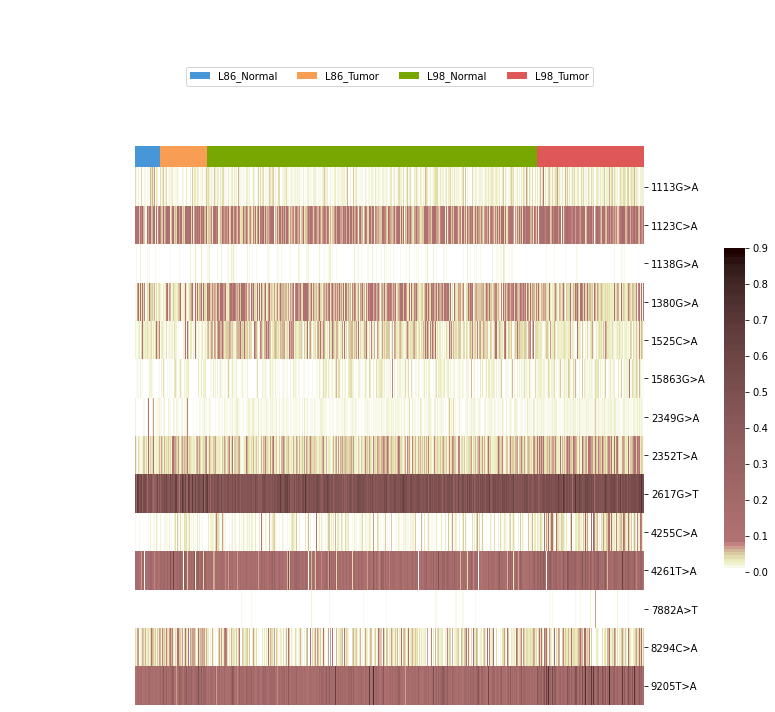

In [48]:
## plot
mtSNP_ids = heatmap_df.index
cell_label = df_filtered['sample_label']
id_uniq = np.unique(cell_label)
print(id_uniq)
vireoSNP.plot.anno_heat(heatmap_df.to_numpy(), col_anno=cell_label, col_order_ids=id_uniq,
                        cmap=segpink, yticklabels=mtSNP_ids)
plt.show()